In [14]:
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit

import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime

from joblib import Parallel, delayed, dump, load

Some useful matplotlib settings:

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Some useful constants:

In [3]:
LAT = 53.24 # Latitude in Grunn
ABOVE_15 = False # Use the 'above 15 deg altitude' condition

date_signature = datetime.now().strftime('%d_%h_%Y')

Select the aperture: `telescope`, `guider`, or `finder`

In [5]:
aperture_name = widgets.Dropdown(
    options=['telescope', 'guider', 'finder'],
    value='telescope',
    description='Aperture:',
)

display(aperture_name)

Dropdown(description='Aperture:', options=('telescope', 'guider', 'finder'), value='telescope')

# Generating obstruction grids

Define a function to extract the file name of the joblib data files:

In [6]:
def file_name(n, ap_name='telescope'):
    fn = '../../scripts/data/' + str(aperture_name.value) + '/blocked_grid_az_' + str(n) + '.joblib'

    return fn

Combine the 2D data sets to create one 3D dataset of dimensions equal to the Az, HA, and Dec data.

In [7]:
# Empty array to store the new 3D data set in
obstr_cube = []

az_range = np.arange(0, 360, 1)

for n_az in az_range:
    with open(file_name(n_az), 'rb') as f:
        data = load(f)
        obstr_cube.append(data)

obstr_cube = np.array(obstr_cube)

with open('data/obstruction_cube_{}_{}.npy'.format(aperture_name.value, date_signature), 'wb') as f:
    np.save(f, obstr_cube)

Create a 3D grid of the HA, Dec, and Az. Calculate the altitude of the telescope & select all points above 15 degrees.

In [8]:
def altitude(ha, dec):
    """Returns altitude in deg."""
    lat = np.radians(LAT)
    dec = np.radians(dec)
    ha  = np.radians(ha)
    
    term_1 = np.sin(dec)*np.sin(lat)
    term_2 = np.cos(dec)*np.cos(lat)*np.cos(ha)
    
    a = np.degrees(np.arcsin(term_1 + term_2))
    
    return a

Then select the data points from the cube for with $a>15\ \text{deg}$ and the $\text{obstruction}\, \%$ is zero!

In [9]:
_az = np.linspace(0, 359, 360)
_ha = np.linspace(-179, 180, 360) 
_dec = np.linspace(-90, 90, 181)

az, ha, dec = np.meshgrid(_az, _ha, _dec, indexing='ij')

Define conditions for selecting the coordinates

In [10]:
alt = altitude(ha, dec)

obstr_cond = obstr_cube == obstr_cube.min()
alt_cond = alt >= 15

cond = obstr_cond

if ABOVE_15:
    cond &= alt_cond

Select the HA, Dec, and Az corresponding to no obstruction!

In [11]:
ha_zero = ha[cond]
ha_zero_shifted = np.where(ha_zero < 0, ha_zero + 360, ha_zero) # offset hour angle

dec_zero = dec[cond]
az_zero = az[cond]

Compute the range of HAs and Decs based on the min obstruction condition.

In [12]:
ha_range = np.arange(ha_zero.min(), ha_zero.max() + 1, 1)
ha_range_shifted = np.arange(ha_zero_shifted.min(), ha_zero_shifted.max() + 1, 1)
dec_range = np.arange(dec_zero.min(), dec_zero.max() + 1, 1)

## Plot

<IPython.core.display.Javascript object>


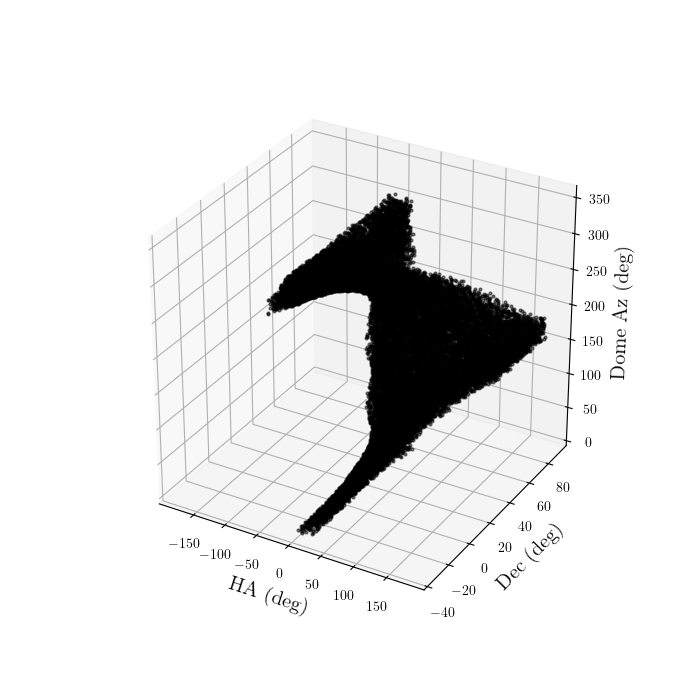

In [13]:
fig = plt.figure(figsize=(7, 7))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)

frame.set_xlabel('HA (deg)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)
frame.set_zlabel('Dome Az (deg)', fontsize=15)

frame.plot(ha_zero[::40], dec_zero[::40], az_zero[::40], color='black', ls='', alpha=0.5, marker='o', ms=2)

# frame.view_init(elev=90, azim=90)

plt.show()

## Optimal $A_d$

Define a function to extract the optimal azimuth from the $A_d$ grid. By selecting the point where (for a constant declination) the HA can move the longest westward, i.e. where the difference in HA is the largest.

In [15]:
def delta_h(h, h_0):    
    return h - h_0  

# def delta_h(h, h_0, m=360):
#     k = (h % m) - (h_0 % m)
#     return k % m

def ha_dist(ha_array, ha_0):
    start = np.argwhere(np.isclose(ha_array, ha_0)).ravel()[0]
    
    diff = np.diff(ha_array)
    diff_shifted = diff[start:]
    
    ha_dist = np.argwhere(~np.isclose(diff_shifted, 1)).ravel()[0]
    
    return ha_dist

Compute the optimal Az, for a certain function to calculate $\Delta h$...

In [107]:
def optimal_az(az_options, ha, dec):
    dec_sel = np.argwhere(np.isclose(dec_zero, dec)).ravel()
    
    azimuths = []
    delta_hs = []
    
    for az in az_options:
        az_sel = np.argwhere(np.isclose(az_zero, az)).ravel()
        
        indices = np.intersect1d(az_sel, dec_sel)
    
        # Extract the range of possible HAs
        hs = ha_zero_shifted[indices] # or use 'ha_zero_shifted'
        
        print('possible dHAs:', np.diff(hs))
        
        if hs.size:
            dh = delta_h(hs, ha)
            
            azimuths.append(az)
            delta_hs.append(dh.max())
    
    azimuths = np.array(azimuths)
    delta_hs = np.array(delta_hs)
    
    return azimuths[delta_hs.argmax()], delta_hs.max()

## Selecting $A_d$ Values Given $(h,\delta)$ Pairs

In [17]:
h0, d0 = 20, 10

In [18]:
ha_sel   = np.argwhere(np.isclose(ha_zero_shifted, h0)).ravel()
dec_sel = np.argwhere(np.isclose(dec_zero, d0)).ravel()

indices = np.intersect1d(ha_sel, dec_sel)

# Find the range of azimuth values
az = az_zero[indices]

In [23]:
az

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61.])

In [25]:
%%timeit
optimal_az(az, h0, d0)

602 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
arr = np.array([354., 355., 356., 357., 358., 359.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
  22.,  23.,  24., 147., 148., 149., 150., 151., 152., 153., 154., 155., 156., 157.,
 158., 159., 160., 161., 162., 163., 164., 165., 166., 167., 168., 169., 170.])

In [27]:
np.diff(arr)

array([   1.,    1.,    1.,    1.,    1., -359.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,  123.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
          1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.])

In [59]:
coords = []
optimal_azimuths = []
hour_angle_diff = []

for h in ha_range_shifted:
    print('ha =', h)
    for d in dec_range:
        # Select indices according to the given ha/dec
        dec_sel = np.argwhere(np.isclose(dec_zero, d)).ravel()
        ha_sel   = np.argwhere(np.isclose(ha_zero_shifted, h)).ravel()
        #h_sel   = np.argwhere(np.isclose(h_selected, h)).ravel()

        indices = np.intersect1d(ha_sel, dec_sel)

        # Find the range of azimuth values
        az = az_zero[indices]

        # Display the results
        if az.size > 0:
            hd_cur = [h, d]
            az_opt, dh = optimal_az(az, *hd_cur)
            
#             print(dh)
            
            coords.append(hd_cur)
            optimal_azimuths.append(az_opt)
            hour_angle_diff.append(dh)

coords = np.array(coords)
optimal_azimuths = np.array(optimal_azimuths)
hour_angle_diff = np.array(hour_angle_diff)

ha = 0.0
ha = 1.0


KeyboardInterrupt: 

In [ ]:
# coords = []
# optimal_azimuths = []
# hour_angle_diff = []

# def gen_opt_az(h):
#     for d in dec_range:
#         # Select indices according to the given ha/dec
#         dec_sel = np.argwhere(np.isclose(dec_zero, d)).ravel()
#         ha_sel   = np.argwhere(np.isclose(ha_zero_shifted, h)).ravel()
#         #ha_sel   = np.argwhere(np.isclose(h_selected, h)).ravel()

#         indices = np.intersect1d(ha_sel, dec_sel)

#         # Find the range of azimuth values
#         az = az_zero[indices]

#         # Display the results
#         if az.size > 0:
#             hd_cur = [h, d]
#             az_opt, dh = optimal_az(az, *hd_cur)
            
# #             print(dh)
            
#             coords.append(hd_cur)
#             optimal_azimuths.append(az_opt)
#             hour_angle_diff.append(dh)
    
#     print('finished ha = {:>3.0f} degrees at {}'.format(h, datetime.now().strftime('%H:%M')))

# results = Parallel(n_jobs=8, backend='multiprocessing')(delayed(gen_opt_az)(h) for h in ha_range_shifted)

## Store the Data

Zero obstruction:

In [ ]:
zero_obstruction_coords = np.column_stack([ha_zero, dec_zero, az_zero])
np.savetxt('data/zero_obstruction_{}_{}.csv'.format(aperture_name.value, date_signature), zero_obstruction_coords, delimiter=',')

Optimal azimuths:

In [ ]:
opt = np.column_stack([coords[:, 0], coords[:, 1], optimal_azimuths, hour_angle_diff/15])
np.savetxt('data/optimal_az_{}_{}.csv'.format(aperture_name.value, date_signature), opt, delimiter=',')

# Interactivelly Selecting $A_d$

In [114]:
@widgets.interact(ha=(ha_zero_shifted.min(), ha_zero_shifted.max(), 1.0), dec=(dec_zero.min(), dec_zero.max(), 1.0))
def update(ha=0.0, dec=0.0):
    # Select indices according to the given ha/dec
    dec_sel = np.argwhere(np.isclose(dec_zero, dec)).ravel()
    ha_sel   = np.argwhere(np.isclose(ha_zero_shifted, ha)).ravel()
    
    indices = np.intersect1d(ha_sel, dec_sel)
    
    # Find the range of azimuth values
    az = az_zero[indices]
    
    # Display the results
    if not az.size:
        print('No azimuths available!')
    else:
        print('Available az (deg): {:} az points\n'.format(az.size))
    
        for a in az:
            print('{:.0f}'.format(a), end=', ')
        
        hd_cur = [ha, dec]
        az_opt, dh = optimal_az(az, *hd_cur)
        
        print('\n\nThe optimal value is {:.0f} deg'.format(az_opt))
        print('\n\nThe max. HA difference is {:.0f} deg'.format(dh))

interactive(children=(FloatSlider(value=0.0, description='ha', max=359.0, step=1.0), FloatSlider(value=0.0, de…

In [78]:
h, d = (343, 0)

In [82]:
possible_hs = np.array([343., 344., 345., 346., 347., 348., 349., 350., 351., 352., 353., 354., 355., 356.,
 357., 358., 359.,   0.,   1.,   2.,   3.])

In [83]:
possible_hs

array([343., 344., 345., 346., 347., 348., 349., 350., 351., 352., 353.,
       354., 355., 356., 357., 358., 359.,   0.,   1.,   2.,   3.])

In [121]:
try:
    start = np.argwhere(np.isclose(possible_hs, h)).ravel()[0]
#     print(start)
except IndexError:
    pass

diff = np.diff(possible_hs)
diff_shifted = diff[start:]

if np.all(np.isclose(diff_shifted, 1)):
    print('HA distance =', diff_shifted.size)
    
ha_dist_options = np.argwhere(~np.isclose(diff_shifted, 1)).ravel()

ha_1 = ha_dist_options[0]

if np.isclose(diff_shifted[ha_dist], -359):
    pre_break = start + ha_dist
    post_break = start + ha_dist + 1
    
    print(diff_shifted.size)

# print(ha_dist)

20


In [106]:
ha_dist_options.size > 1

1